# 03_feature_engineering - Simple Feature Creation

This notebook applies simple feature engineering: log-transform of amount, extract hour/weekday from timestamps (if present), and compute simple per-account aggregates (total incoming/outgoing, counts). Each operation is placed in its own cell for clarity.

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..','src')))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engineering import apply_feature_engineering

RAW = os.path.abspath(os.path.join('..','data','raw'))
PROCESSED = os.path.abspath(os.path.join('..','data','processed'))

csvs = [f for f in os.listdir(PROCESSED) if f.lower().endswith('.csv')] if os.path.exists(PROCESSED) else []
print('Processed CSVs found:', csvs)


Processed CSVs found: ['cleaned.csv', 'clustering_predictions.csv', 'clustering_results.csv', 'features.csv', 'features_pca.csv']


In [2]:
# Load cleaned data if available, otherwise load first raw CSV
cleaned_path = os.path.join(PROCESSED, 'cleaned.csv')
if os.path.exists(cleaned_path):
    df = pd.read_csv(cleaned_path)
    print('Loaded cleaned:', cleaned_path)
else:
    raw_csvs = [f for f in os.listdir(RAW) if f.lower().endswith('.csv')] if os.path.exists(RAW) else []
    if not raw_csvs:
        print('No CSVs found in data/raw. Please add dataset.')
    else:
        df = pd.read_csv(os.path.join(RAW, raw_csvs[0]))
        print('Loaded raw:', raw_csvs[0])


Loaded cleaned: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\cleaned.csv


In [3]:
# Show first rows
try:
    display(df.head())
except NameError:
    print('No dataframe loaded.')


,Time,Date,Sender_account,Receiver_account,Amount,Is_laundering,timestamp,Payment_currency_Albanian lek,Payment_currency_Dirham,Payment_currency_Euro,...,Receiver_bank_location_UAE,Receiver_bank_location_UK,Receiver_bank_location_USA,Payment_type_ACH,Payment_type_Cash Deposit,Payment_type_Cash Withdrawal,Payment_type_Cheque,Payment_type_Credit card,Payment_type_Cross-border,Payment_type_Debit card
0,5387,136,5402012602,1511156942,4266.06,0,2023-02-20 07:36:23,False,False,False,...,False,True,False,True,False,False,False,False,False,False
1,4725,151,8401844213,3742608142,10624.52,0,2023-03-07 06:42:14,False,False,False,...,False,True,False,False,False,False,False,False,False,True
2,10308,1,6465571183,8296980377,180.22,0,2022-10-08 10:06:13,False,False,False,...,False,True,False,False,False,False,False,True,False,False
3,24742,224,2612843052,960360534,13546.65,0,2023-05-19 16:43:42,False,False,False,...,False,True,False,False,False,False,True,False,False,False
4,21388,315,2818419843,7683774623,8790.08,1,2023-08-18 15:08:57,False,False,False,...,False,True,False,False,False,False,False,False,True,False


In [4]:
# Apply feature engineering and save features
from feature_engineering import apply_feature_engineering, save_features

print('Before shape:', df.shape)
features = apply_feature_engineering(df, save_path=os.path.join(PROCESSED,'features.csv'))
print('After shape:', features.shape)


Before shape: (58817, 76)
After shape: (58817, 84)


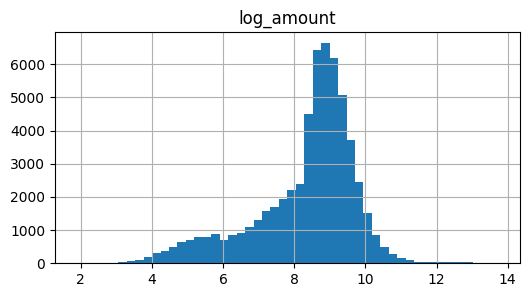

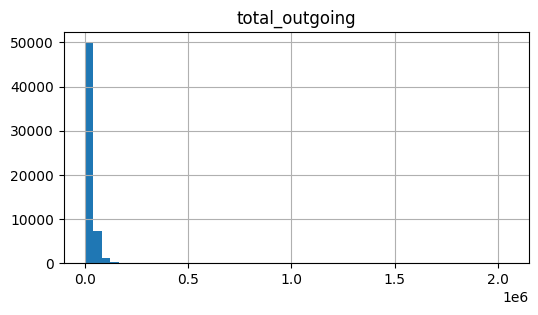

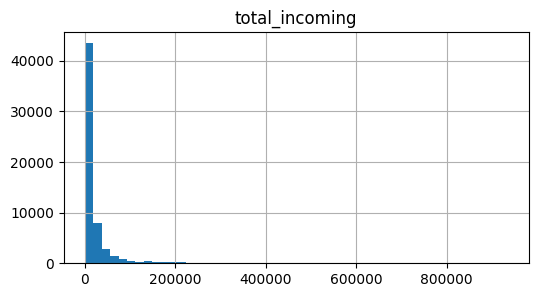

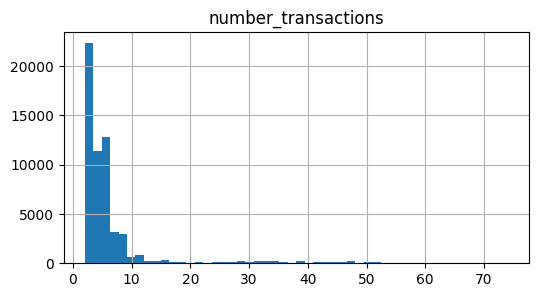

In [5]:
# Histograms of new features: log_amount, total_outgoing, total_incoming, number_transactions
import matplotlib.pyplot as plt

if 'log_amount' in features.columns:
    plt.figure(figsize=(6,3))
    features['log_amount'].hist(bins=50)
    plt.title('log_amount')
    plt.show()

for col in ['total_outgoing','total_incoming','number_transactions']:
    if col in features.columns:
        plt.figure(figsize=(6,3))
        features[col].hist(bins=50)
        plt.title(col)
        plt.show()


# Dimensionality Reduction with PCA

Apply Principal Component Analysis (PCA) to reduce the dimensionality of the feature space while retaining most of the variance. This helps with:
- Removing multicollinearity
- Reducing overfitting
- Improving model training speed
- Capturing the most important patterns in the data

In [6]:
# Prepare data for PCA: select only numeric features and standardize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select numeric features only (exclude target and ID columns)
exclude_cols = ['Is_laundering', 'Laundering_type', 'id', 'transaction_id', 'account_id', 'customer_id']
numeric_features = features.select_dtypes(include=[np.number])
numeric_features = numeric_features.drop(columns=[col for col in exclude_cols if col in numeric_features.columns], errors='ignore')

print(f'Number of numeric features before PCA: {numeric_features.shape[1]}')
print(f'Features: {list(numeric_features.columns)}')

Number of numeric features before PCA: 13
Features: ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'log_amount', 'hour', 'weekday', 'total_outgoing', 'num_outgoing', 'total_incoming', 'num_incoming', 'number_transactions']


In [7]:
# Standardize the features (PCA is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

print(f'Scaled data shape: {X_scaled.shape}')
print(f'Mean after scaling: {X_scaled.mean(axis=0)[:3]} (should be ~0)')
print(f'Std after scaling: {X_scaled.std(axis=0)[:3]} (should be ~1)')

Scaled data shape: (58817, 13)
Mean after scaling: [ 4.96511322e-17 -1.52456761e-16  1.58859462e-17] (should be ~0)
Std after scaling: [1. 1. 1.] (should be ~1)


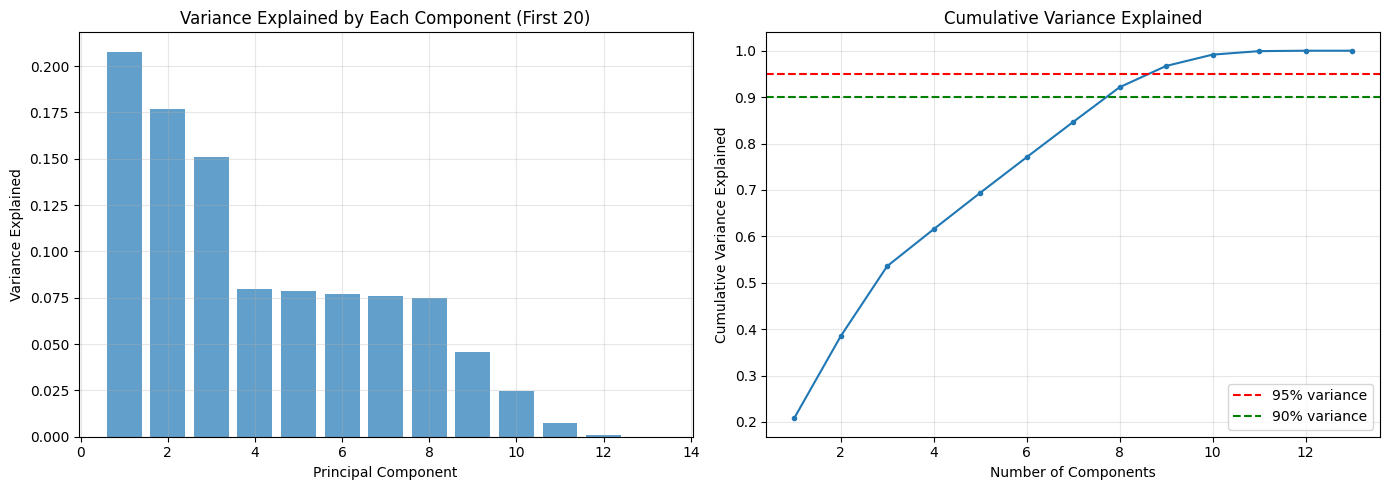


Number of components for 90% variance: 8 (from 13)
Number of components for 95% variance: 9 (from 13)
Dimensionality reduction: 13 → 9 features


In [8]:
# Analyze variance explained by each principal component
# First, fit PCA with all components to see cumulative variance
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_[:20], alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Variance Explained by Each Component (First 20)')
axes[0].grid(alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', markersize=3)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1].axhline(y=0.90, color='g', linestyle='--', label='90% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f'\nNumber of components for 90% variance: {n_components_90} (from {len(pca_full.components_)})')
print(f'Number of components for 95% variance: {n_components_95} (from {len(pca_full.components_)})')
print(f'Dimensionality reduction: {len(pca_full.components_)} → {n_components_95} features')

In [9]:
# Apply PCA with optimal number of components (95% variance)
pca_optimal = PCA(n_components=n_components_95)
X_pca = pca_optimal.fit_transform(X_scaled)

print(f'Original feature space: {X_scaled.shape[1]} dimensions')
print(f'PCA feature space: {X_pca.shape[1]} dimensions')
print(f'Variance retained: {pca_optimal.explained_variance_ratio_.sum():.4f}')

# Create PCA feature dataframe
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns, index=features.index)

# Add back the target variable and important ID columns
for col in ['Is_laundering', 'Laundering_type']:
    if col in features.columns:
        df_pca[col] = features[col].values

print(f'\nPCA features shape: {df_pca.shape}')
display(df_pca.head())

Original feature space: 13 dimensions
PCA feature space: 9 dimensions
Variance retained: 0.9671

PCA features shape: (58817, 10)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Is_laundering
0,-0.673725,-0.583766,-1.858939,0.255228,1.176754,-0.177574,-1.054344,1.151349,-0.089583,0
1,-0.312386,0.060437,-2.089563,0.270959,0.246459,0.100933,-0.126087,1.713227,0.176180,0
2,0.021988,-1.635357,-0.904622,0.996242,-2.167694,-0.810293,-0.229892,-0.747501,-1.313732,0
3,-0.954920,0.649242,0.272904,-0.542786,0.980344,1.287207,-0.615995,-0.516313,0.404539,0
4,0.606301,0.851477,0.114310,-1.975588,0.356965,0.492218,1.482392,-0.302513,-0.336896,1


In [10]:
# Analyze the most important original features for each principal component
n_top_features = 5  # Show top 5 features per component

print(f'Top {n_top_features} features contributing to each principal component:\n')

for i in range(min(5, len(pca_optimal.components_))):  # Show first 5 PCs
    pc = pca_optimal.components_[i]
    top_indices = np.argsort(np.abs(pc))[-n_top_features:][::-1]
    
    print(f'PC{i+1} (explains {pca_optimal.explained_variance_ratio_[i]:.2%} variance):')
    for idx in top_indices:
        feature_name = numeric_features.columns[idx]
        weight = pc[idx]
        print(f'  {feature_name:30s}: {weight:+.4f}')
    print()

Top 5 features contributing to each principal component:

PC1 (explains 20.78% variance):
  number_transactions           : +0.5832
  num_incoming                  : +0.5432
  num_outgoing                  : +0.4304
  total_incoming                : +0.3535
  total_outgoing                : +0.1407

PC2 (explains 17.67% variance):
  Amount                        : +0.5702
  log_amount                    : +0.4492
  total_outgoing                : +0.4381
  total_incoming                : +0.4208
  num_outgoing                  : -0.1973

PC3 (explains 15.11% variance):
  hour                          : +0.6860
  Time                          : +0.6859
  Amount                        : -0.1187
  number_transactions           : +0.1065
  num_incoming                  : +0.0970

PC4 (explains 7.97% variance):
  Sender_account                : +0.5224
  total_outgoing                : +0.4688
  num_outgoing                  : +0.3961
  total_incoming                : -0.3222
  num_incoming

In [11]:
# Save PCA-transformed features
import numpy as np

pca_features_path = os.path.join(PROCESSED, 'features_pca.csv')
df_pca.to_csv(pca_features_path, index=False)
print(f'PCA features saved to: {pca_features_path}')

# Also save the scaler and PCA model for future use
import joblib
scaler_path = os.path.join(PROCESSED, 'scaler.pkl')
pca_path = os.path.join(PROCESSED, 'pca_model.pkl')

joblib.dump(scaler, scaler_path)
joblib.dump(pca_optimal, pca_path)

print(f'Scaler saved to: {scaler_path}')
print(f'PCA model saved to: {pca_path}')
print(f'\nNote: Use features_pca.csv for modeling to benefit from dimensionality reduction')

PCA features saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\features_pca.csv
Scaler saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\scaler.pkl
PCA model saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\pca_model.pkl

Note: Use features_pca.csv for modeling to benefit from dimensionality reduction
